In [1]:
from fastmri.data.mri_data import fetch_dir
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.data.transforms import UnetDataTransform
from fastmri.pl_modules import FastMriDataModule, UnetModule
from fastmri.data import transforms, mri_data
import pathlib
import torch
import matplotlib.pyplot as plt
import numpy as np


In [2]:
CHALLENGE = 'singlecoil'
MASK_TYPE = 'random'
center_fractions = [0.08]
accelerations = [4]


mask = create_mask_for_mask_type(
        MASK_TYPE, center_fractions, accelerations
    )

In [3]:
train_transform = UnetDataTransform(CHALLENGE, mask_func=mask, use_seed=False)

In [4]:
'''
download knee singlecoil val data by https://fastmri.med.nyu.edu/
unzip it in ./fastmri_data/singlecoil_val
'''

'\ndownload knee singlecoil val data by https://fastmri.med.nyu.edu/\nunzip it in ./fastmri_data/singlecoil_val\n'

In [5]:
dataset = mri_data.SliceDataset(
    root=pathlib.Path(
      './fastmri_data/singlecoil_val'
    ),
    transform=train_transform,
    challenge='singlecoil'
)

In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

In [7]:
image, target, _, _, _, _, _ = next(iter(dataloader))

In [8]:
image.shape, target.shape

(torch.Size([1, 320, 320]), torch.Size([1, 320, 320]))

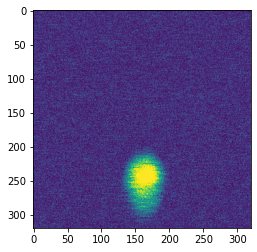

In [9]:
plt.imshow(image.view(320, 320).numpy())

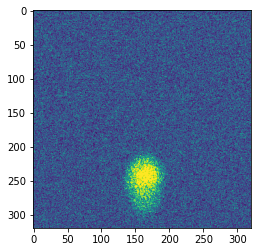

In [10]:
plt.imshow(target.view(320, 320).numpy())

In [11]:
import torch
import torch.nn as nn
import memcnn

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [12]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [13]:
from collections import OrderedDict
import copy

def conv2d_to_invertible(block, inplace=True) : 
    replace_modules = copy.deepcopy(block._modules)     
    #print("before for loop", replace_modules)
    for i, (name, module) in enumerate(block.named_modules()) : 
        #print(i, name)
        if '.' not in name and isinstance(module, torch.nn.Conv2d) \
             and not isinstance(module, memcnn.InvertibleModuleWrapper):
            in_c = module.in_channels
            out_c = module.out_channels
            k = module.kernel_size
            s = module.stride
            p = module.padding
            d = module.dilation
            t = module.transposed
            op = module.output_padding
            g = module.groups
            if in_c == out_c : 
                #print(name, module, "\t\t-->")
                fm_input_size = in_c // 2
                gm_input_size = in_c - fm_input_size
                conv2d = memcnn.InvertibleModuleWrapper(fn= \
                             memcnn.AdditiveCoupling(
                                    Fm=torch.nn.Conv2d(fm_input_size, fm_input_size, k, s, p, d, g),
                                    Gm=torch.nn.Conv2d(gm_input_size, gm_input_size, k, s, p, d, g),
                             ), keep_input=False, keep_input_inverse=False)
                replace_modules[name] = conv2d
                #print(conv2d)
            else : 
               #print("input dim and output dim is not matched")
                pass
    #print("after for loop", replace_modules)       
    block._modules = replace_modules

In [14]:
def dfs_conv2d_to_invertible(top_module, inplace=True) : 
    conv2d_to_invertible(top_module, inplace=True)
    for name, module in top_module._modules.items() : 
        if isinstance(module, memcnn.InvertibleModuleWrapper) : 
            continue
        #print(name, len(module._modules))
        if len(module._modules) > 0 : 
            dfs_conv2d_to_invertible(module)

In [ ]:
unet_model = Unet(1)